In [13]:
import os
import time
import torch
import subprocess as sp
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, random_split

%matplotlib inline

In [14]:
base_path = sp.getoutput('git rev-parse --show-toplevel')
os.chdir(base_path)

from src import embed, pred_models, model_helpers

### Data Preparation

In [15]:
# Load data
data_dir = 'data'
file = 'utterances_clean2014-2018.csv'
df_raw = pd.read_csv(os.path.join(base_path, data_dir, file))

/var/folders/1r/lbtr12kn1_x17pfbmlxcjxf40000gn/T/ipykernel_41837/2014623051.py:4: DtypeWarning: Columns (17,60,62) have mixed types. Specify dtype option on import or set low_memory=False.
  df_raw = pd.read_csv(os.path.join(base_path, data_dir, file))


In [16]:
# OPTION 1
# In the context of pandas' groupby and agg methods, 
# 'first' is an aggregation function that returns the 
# first non-null value in each group of values.
df = (df_raw.groupby('case_id')
        .agg({'text': ' '.join, 'win_side': 'first'})
        .reset_index()
        .drop(['case_id'], axis=1))

df.head()

,text,win_side
0,We will hear argument first this morning in Ca...,1.0
1,"We'll hear argument next in Case 12-1497, Kell...",1.0
2,"We will hear argument next in Case 131010, M&G...",1.0
3,We'll hear argument first this morning in Case...,1.0
4,We will hear argument first this morning in Ca...,1.0


In [17]:
# OPTION 2
df = df_raw[['text', 'win_side']]
df.head()

,text,win_side
0,"We'll hear argument next in Case No. 13-553, t...",1.0
1,"Thank you, Mr. Chief Justice, and may it pleas...",1.0
2,"Well, is said that -- it said that in -- in (b...",1.0
3,Right. I -- but I think--,1.0
4,"Another tax that discriminates is all it says,...",1.0


In [18]:
# TO DISCUSS
df.dropna(subset=['win_side'], inplace=True)
df = df[df.win_side != 2]

/var/folders/1r/lbtr12kn1_x17pfbmlxcjxf40000gn/T/ipykernel_41837/1009847024.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(subset=['win_side'], inplace=True)


In [19]:
# Split the dataset into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=123)

### BoW Embedding

In [20]:
# Bag of Words
vocab = embed.get_vocab(train_df, min_freq=10)
vocab_size = len(vocab)
vocab_size

8155

### Create training, validation, and testing dataloaders

In [21]:
BATCH_SIZE = 64

train_valid_data = list(train_df.values)
num_train = int(len(train_valid_data) * 0.95)
num_valid = len(train_valid_data) - num_train
train_data, valid_data = random_split(
    train_valid_data, [num_train, num_valid])
test_data, _ = random_split(list(test_df.values), [len(test_df), 0])

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE,
                              shuffle=True, 
                              collate_fn=lambda batch: embed.collate_into_bow(batch, vocab)) # pass vocab to collate function
valid_dataloader = DataLoader(valid_data, batch_size=BATCH_SIZE,
                              shuffle=False, 
                              collate_fn=lambda batch: embed.collate_into_bow(batch, vocab))
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE,
                             shuffle=False, 
                             collate_fn=lambda batch: embed.collate_into_bow(batch, vocab))

### Training

In [22]:
# BoW NN Classifier
hidden_dim = 300
model = pred_models.BoWNNClassifier(vocab_size=vocab_size, hidden_dim=hidden_dim, output_dim=1)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torch/_tensor.py:775: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


At iteration 200 the loss is 0.680.
At iteration 400 the loss is 0.589.
At iteration 600 the loss is 0.551.
At iteration 800 the loss is 0.602.
After epoch 1 the validation accuracy is 0.723.
At iteration 200 the loss is 0.553.
At iteration 400 the loss is 0.470.
At iteration 600 the loss is 0.541.
At iteration 800 the loss is 0.451.
After epoch 2 the validation accuracy is 0.732.
At iteration 200 the loss is 0.473.
At iteration 400 the loss is 0.542.
At iteration 600 the loss is 0.414.
At iteration 800 the loss is 0.391.
After epoch 3 the validation accuracy is 0.729.
At iteration 200 the loss is 0.372.
At iteration 400 the loss is 0.341.
At iteration 600 the loss is 0.456.
At iteration 800 the loss is 0.493.
After epoch 4 the validation accuracy is 0.733.
At iteration 200 the loss is 0.355.
At iteration 400 the loss is 0.297.
At iteration 600 the loss is 0.384.
At iteration 800 the loss is 0.439.
After epoch 5 the validation accuracy is 0.710.
At iteration 200 the loss is 0.251.
At i

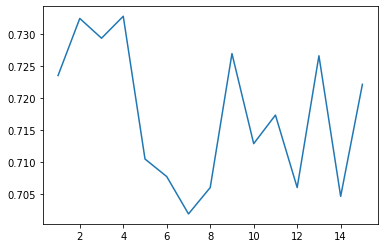

In [23]:
EPOCHS = 15
loss_function = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

accuracies=[]
for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    model_helpers.train_an_epoch(model, train_dataloader, optimizer, loss_function)
    accuracy = model_helpers.get_accuracy(model, valid_dataloader, 0.5)
    accuracies.append(accuracy)
    time_taken = time.time() - epoch_start_time
    print(f'After epoch {epoch} the validation accuracy is {accuracy:.3f}.')
    
plt.plot(range(1, EPOCHS+1), accuracies)

In [24]:
# Best number of epochs following validation results
EPOCHS = torch.argmax(torch.tensor(accuracies))
EPOCHS

tensor(3)

In [25]:
# Retrain model at best number of epochs and calculate test accuracy
model = pred_models.BoWNNClassifier(vocab_size=vocab_size, hidden_dim=hidden_dim, output_dim=1)
loss_function = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(1, EPOCHS + 1):
    model_helpers.train_an_epoch(model, train_dataloader, optimizer, loss_function)

At iteration 200 the loss is 0.092.
At iteration 400 the loss is 0.091.
At iteration 600 the loss is 0.108.
At iteration 800 the loss is 0.136.
At iteration 200 the loss is 0.211.
At iteration 400 the loss is 0.136.
At iteration 600 the loss is 0.123.
At iteration 800 the loss is 0.140.
At iteration 200 the loss is 0.120.
At iteration 400 the loss is 0.112.
At iteration 600 the loss is 0.106.
At iteration 800 the loss is 0.163.
Test accuracy is 0.732.


In [26]:
test_accuracy = model_helpers.get_accuracy(model, test_dataloader, 0.5)
print(f'Test accuracy is {test_accuracy:.3f}.')

Test accuracy is 0.732.
